In [26]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
from keras import Model

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap, BoundaryNorm

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 0


In [27]:
data = np.load("/kaggle/input/an2dl-hw22024-2025/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


/tmp/ipykernel_30/2378697683.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("viridis", num_classes)  # Create a colormap with unique colors


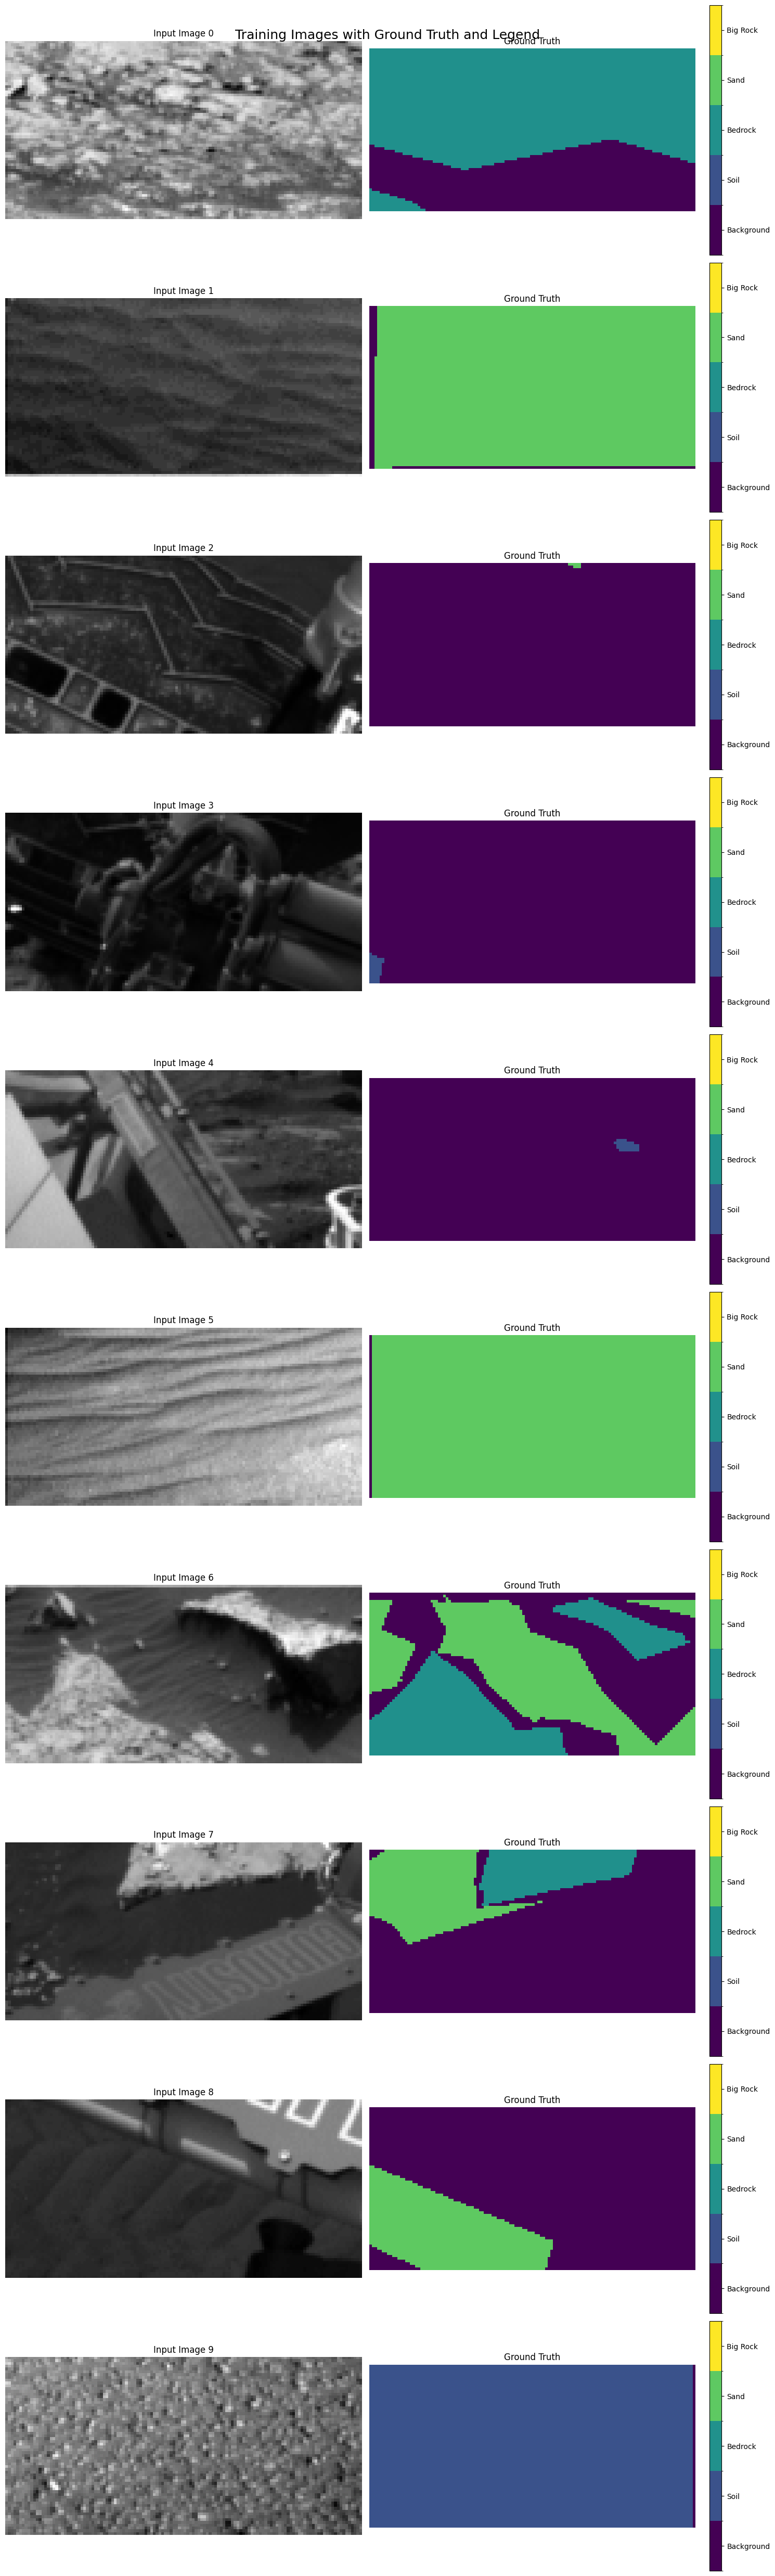

In [28]:
# Define a colormap and class labels
num_classes = len(np.unique(y_train))  # Determine the number of classes from the labels
colors = plt.cm.get_cmap("viridis", num_classes)  # Create a colormap with unique colors
class_labels = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

# Function to visualize images alongside their ground truth
def plot_images_with_ground_truth_and_legend(images, labels, rows=10, cols=1, title=""):
    plt.figure(figsize=(15, rows * 5))  # Adjust figure size for larger images
    for i in range(rows * cols):
        if i >= len(images):
            break
        # Input Image
        plt.subplot(rows, cols * 2, i * 2 + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Input Image {i}", fontsize=12)
        plt.axis("off")
        
        # Ground Truth
        plt.subplot(rows, cols * 2, i * 2 + 2)
        im = plt.imshow(labels[i], cmap=colors, norm=BoundaryNorm(np.arange(num_classes + 1) - 0.5, num_classes))
        plt.title("Ground Truth", fontsize=12)
        plt.axis("off")
        
    
        cbar = plt.colorbar(im, ax=plt.gca(), orientation="vertical", fraction=0.046, pad=0.04)
        cbar.set_ticks(np.arange(num_classes))
        cbar.set_ticklabels(class_labels)
        cbar.ax.tick_params(labelsize=10)

    plt.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

# Display a subset of Training Images with their Ground Truth
plot_images_with_ground_truth_and_legend(X_train, y_train, rows=10, cols=1, title="Training Images with Ground Truth and Legend")


Mean Intensity: 61.66
Standard Deviation: 28.02
Min Intensity: 2.0
Max Intensity: 254.0
Percentiles (25%, 50%, 75%): [41. 60. 81.]


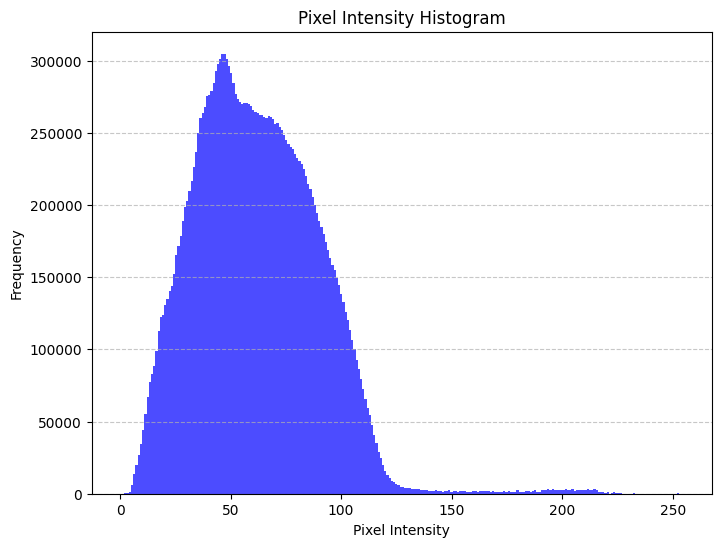

In [29]:
# Flatten the pixel values
all_pixels = X_train.flatten()

# Compute Statistics
mean_intensity = np.mean(all_pixels)
std_intensity = np.std(all_pixels)
min_intensity = np.min(all_pixels)
max_intensity = np.max(all_pixels)
percentiles = np.percentile(all_pixels, [25, 50, 75])

# Print Statistics
print(f"Mean Intensity: {mean_intensity:.2f}")
print(f"Standard Deviation: {std_intensity:.2f}")
print(f"Min Intensity: {min_intensity}")
print(f"Max Intensity: {max_intensity}")
print(f"Percentiles (25%, 50%, 75%): {percentiles}")

# Plot Histogram
plt.figure(figsize=(8, 6))
plt.hist(all_pixels, bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title("Pixel Intensity Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Mean Intensity: 60.75
Standard Deviation: 26.93
Min Intensity: 1
Max Intensity: 255
Percentiles (25%, 50%, 75%): [40. 60. 81.]


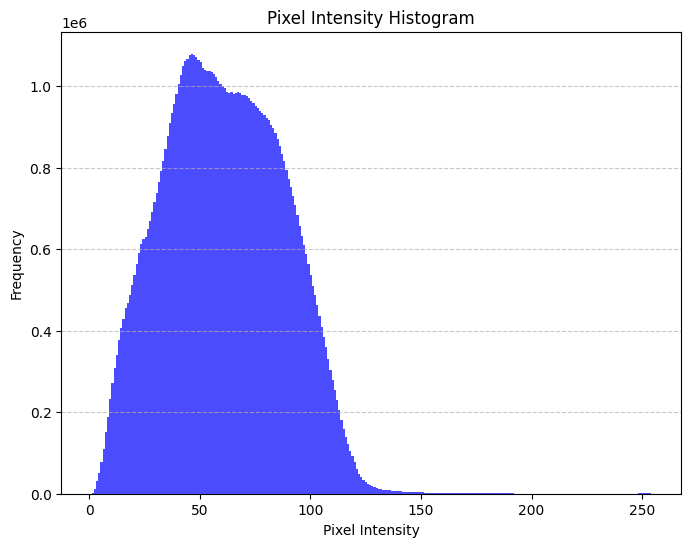

In [30]:
# Flatten the pixel values
all_pixels = X_test.flatten()

# Compute Statistics
mean_intensity = np.mean(all_pixels)
std_intensity = np.std(all_pixels)
min_intensity = np.min(all_pixels)
max_intensity = np.max(all_pixels)
percentiles = np.percentile(all_pixels, [25, 50, 75])

# Print Statistics
print(f"Mean Intensity: {mean_intensity:.2f}")
print(f"Standard Deviation: {std_intensity:.2f}")
print(f"Min Intensity: {min_intensity}")
print(f"Max Intensity: {max_intensity}")
print(f"Percentiles (25%, 50%, 75%): {percentiles}")

# Plot Histogram
plt.figure(figsize=(8, 6))
plt.hist(all_pixels, bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title("Pixel Intensity Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

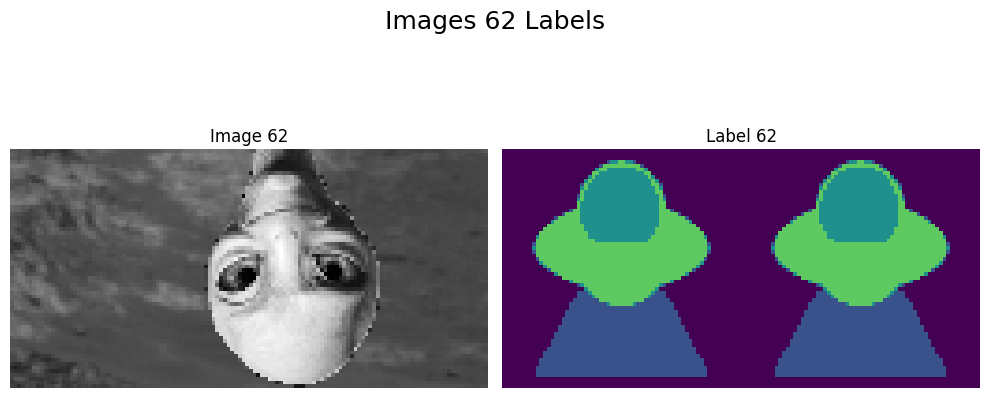

Identical images: 1, Identical labels: 110
Total images to remove: 110
Removed 110 images/labels.


Original dataset size: 2615, Filtered dataset size: 2505


In [31]:
def remove_images_and_labels(X_train, y_train, index1):
    # Display the specified images and their ground truth
    def plot_specific_images(images, labels, indices, title):
        plt.figure(figsize=(10, len(indices) * 5))
        for i, idx in enumerate(indices):
            plt.subplot(len(indices), 2, 2 * i + 1)
            plt.imshow(images[idx], cmap="gray")
            plt.title(f"Image {idx}", fontsize=12)
            plt.axis("off")

            plt.subplot(len(indices), 2, 2 * i + 2)
            plt.imshow(labels[idx], cmap=colors, norm=BoundaryNorm(np.arange(num_classes + 1) - 0.5, num_classes))
            plt.title(f"Label {idx}", fontsize=12)
            plt.axis("off")

        plt.suptitle(title, fontsize=18)
        plt.tight_layout()
        plt.show()

    # Show images 62 and 79 with their labels
    plot_specific_images(X_train, y_train, [index1], title="Images 62 Labels")

    # Get the labels (as images) of the specified indices
    label1 = y_train[index1]

    # Find indices of images identical to images 62
    identical_images_1 = [i for i in range(len(X_train)) if np.array_equal(X_train[i], X_train[index1])]

    # Combine indices of identical images
    identical_image_indices = set(identical_images_1)

    # Find indices of labels (ground truth) identical to label1 and label2
    identical_labels_1 = [i for i in range(len(y_train)) if np.array_equal(y_train[i], label1)]

    # Combine indices of identical labels
    identical_label_indices = set(identical_labels_1)

    # Combine all indices to remove
    indices_to_remove = identical_image_indices.union(identical_label_indices)

    # Collect the images and labels to display before removal
    removed_images = [X_train[i] for i in indices_to_remove]
    removed_labels = [y_train[i] for i in indices_to_remove]

    # Check how many images/labels are being removed
    print(f"Identical images: {len(identical_image_indices)}, Identical labels: {len(identical_label_indices)}")
    print(f"Total images to remove: {len(indices_to_remove)}")

    # Remove images and corresponding labels
    X_train_filtered = np.delete(X_train, list(indices_to_remove), axis=0)
    y_train_filtered = np.delete(y_train, list(indices_to_remove), axis=0)

    print(f"Removed {len(indices_to_remove)} images/labels.")

    # Display the removed images and their ground truth
    plot_specific_images(removed_images, removed_labels, range(len(removed_images)), title="Removed Images and Their Ground Truth")

    return X_train_filtered, y_train_filtered

# Apply the function to remove unwanted images/labels
X_train_filtered, y_train_filtered = remove_images_and_labels(X_train, y_train, 62)

# Verify changes
print(f"Original dataset size: {len(X_train)}, Filtered dataset size: {len(X_train_filtered)}")


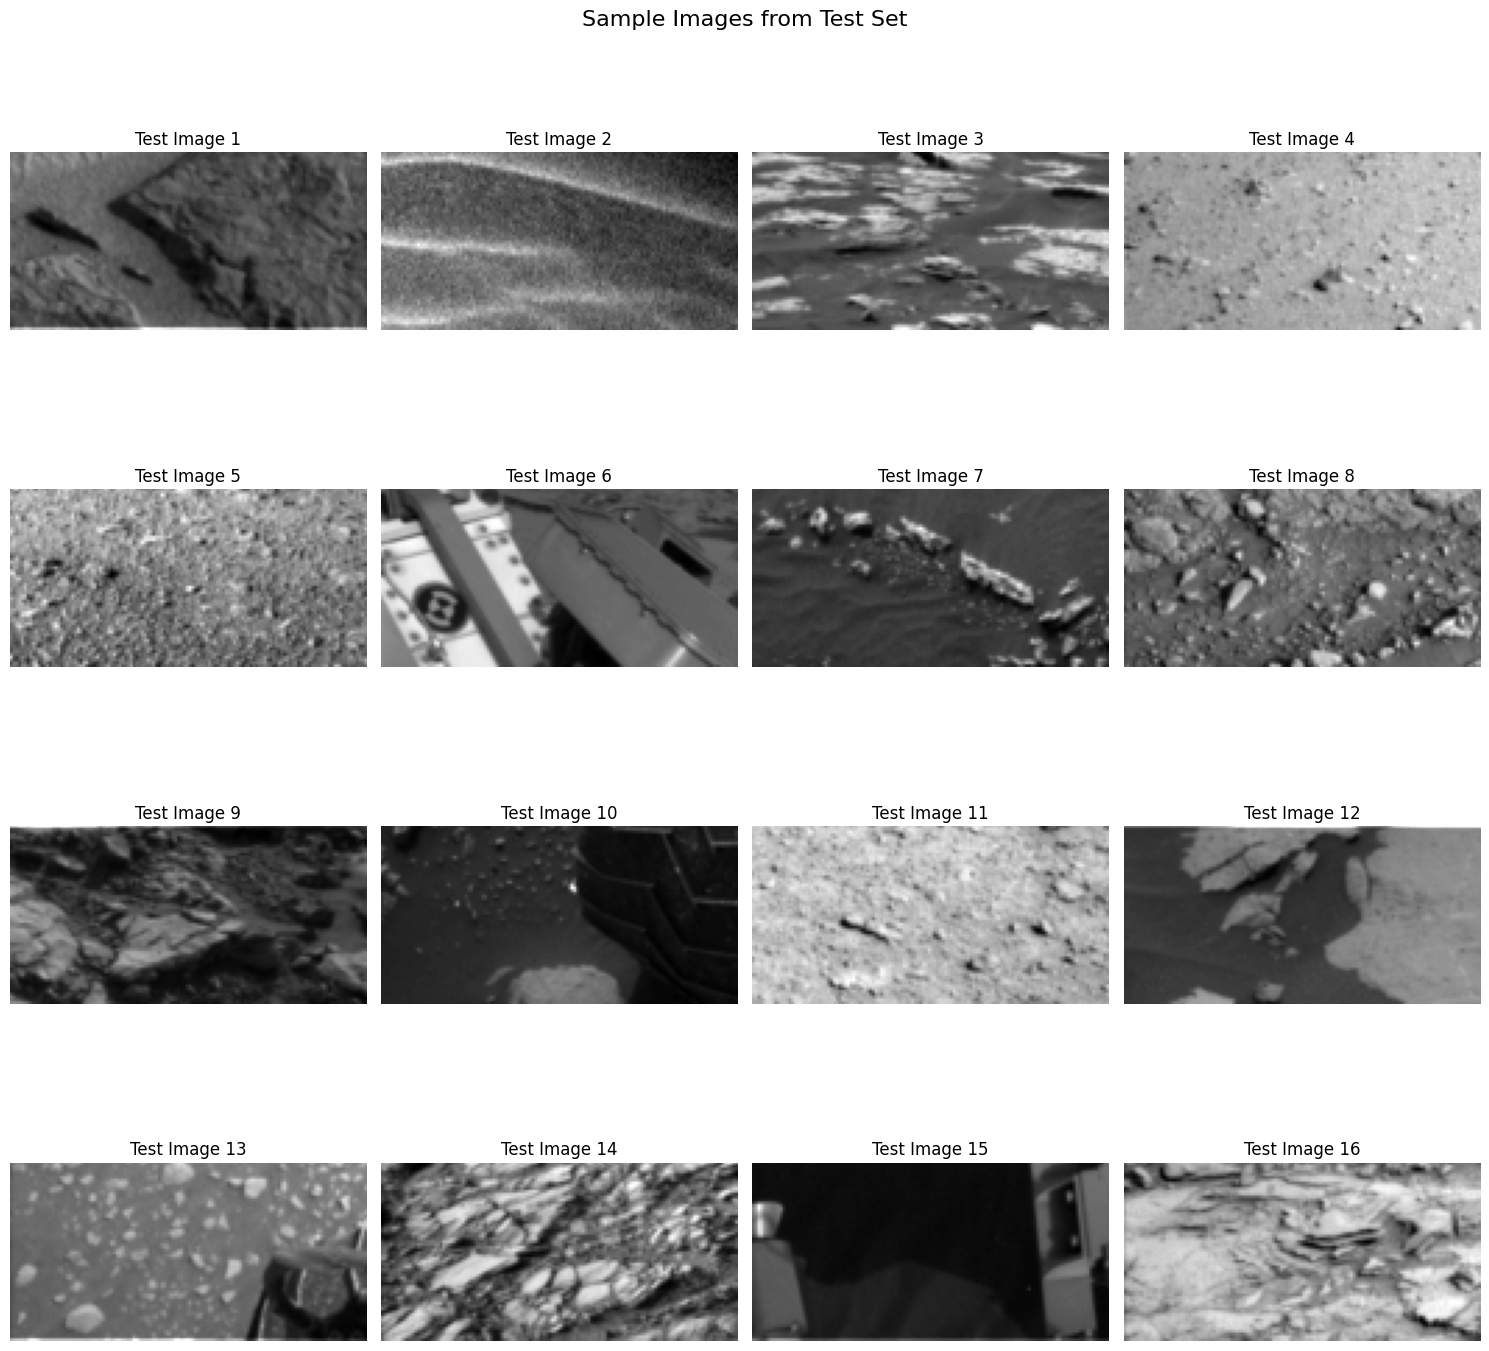

In [32]:
show = True
# Function to visualize images from the test set
def plot_test_images(images, rows=5, cols=5, title="Test Set Images"):
    plt.figure(figsize=(15, 15))
    for i in range(rows * cols):
        if i >= len(images):
            break
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Test Image {i + 1}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

if show:
    # Display a subset of Test Images
    plot_test_images(X_test, rows=4, cols=4, title="Sample Images from Test Set")


In [33]:
show = False
def plot_all_test_images(images, rows=5, cols=5, batch_size=25, start_idx=0):
    total_images = len(images)
    end_idx = min(start_idx + batch_size, total_images)
    print(f"Displaying images {start_idx + 1} to {end_idx} of {total_images}.")
    
    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(start_idx, end_idx):
        plt.subplot(rows, cols, i - start_idx + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Test Image {i + 1}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

if show:
    # Paginate through the test set images
    batch_size = 25  # Change this for more or fewer images per batch
    for start_idx in range(0, len(X_test), batch_size):
        plot_all_test_images(X_test, rows=5, cols=5, batch_size=batch_size, start_idx=start_idx)


In [34]:
# Function to find duplicate image-label pairs
def find_duplicates(images, labels):
    seen = set()
    duplicates = []
    
    # Iterate over all the image-label pairs
    for i, (image, label) in enumerate(zip(images, labels)):
        # Convert image and label arrays to hashable types (tuples)
        image_tuple = tuple(image.flatten())
        label_tuple = tuple(label.flatten())
        
        # Check if the image-label pair already exists in the set
        if (image_tuple, label_tuple) in seen:
            duplicates.append(i)
        else:
            seen.add((image_tuple, label_tuple))
    
    return duplicates

# Find duplicates in training data
duplicates = find_duplicates(X_train_filtered, y_train_filtered)

# Print out the indices of duplicate images
print(f"Found {len(duplicates)} duplicates in the filtered training set.")
if duplicates:
    print(f"Indices of duplicate images: {duplicates}")


Found 0 duplicates in the filtered training set.


Found 7 images with zero ground truth.


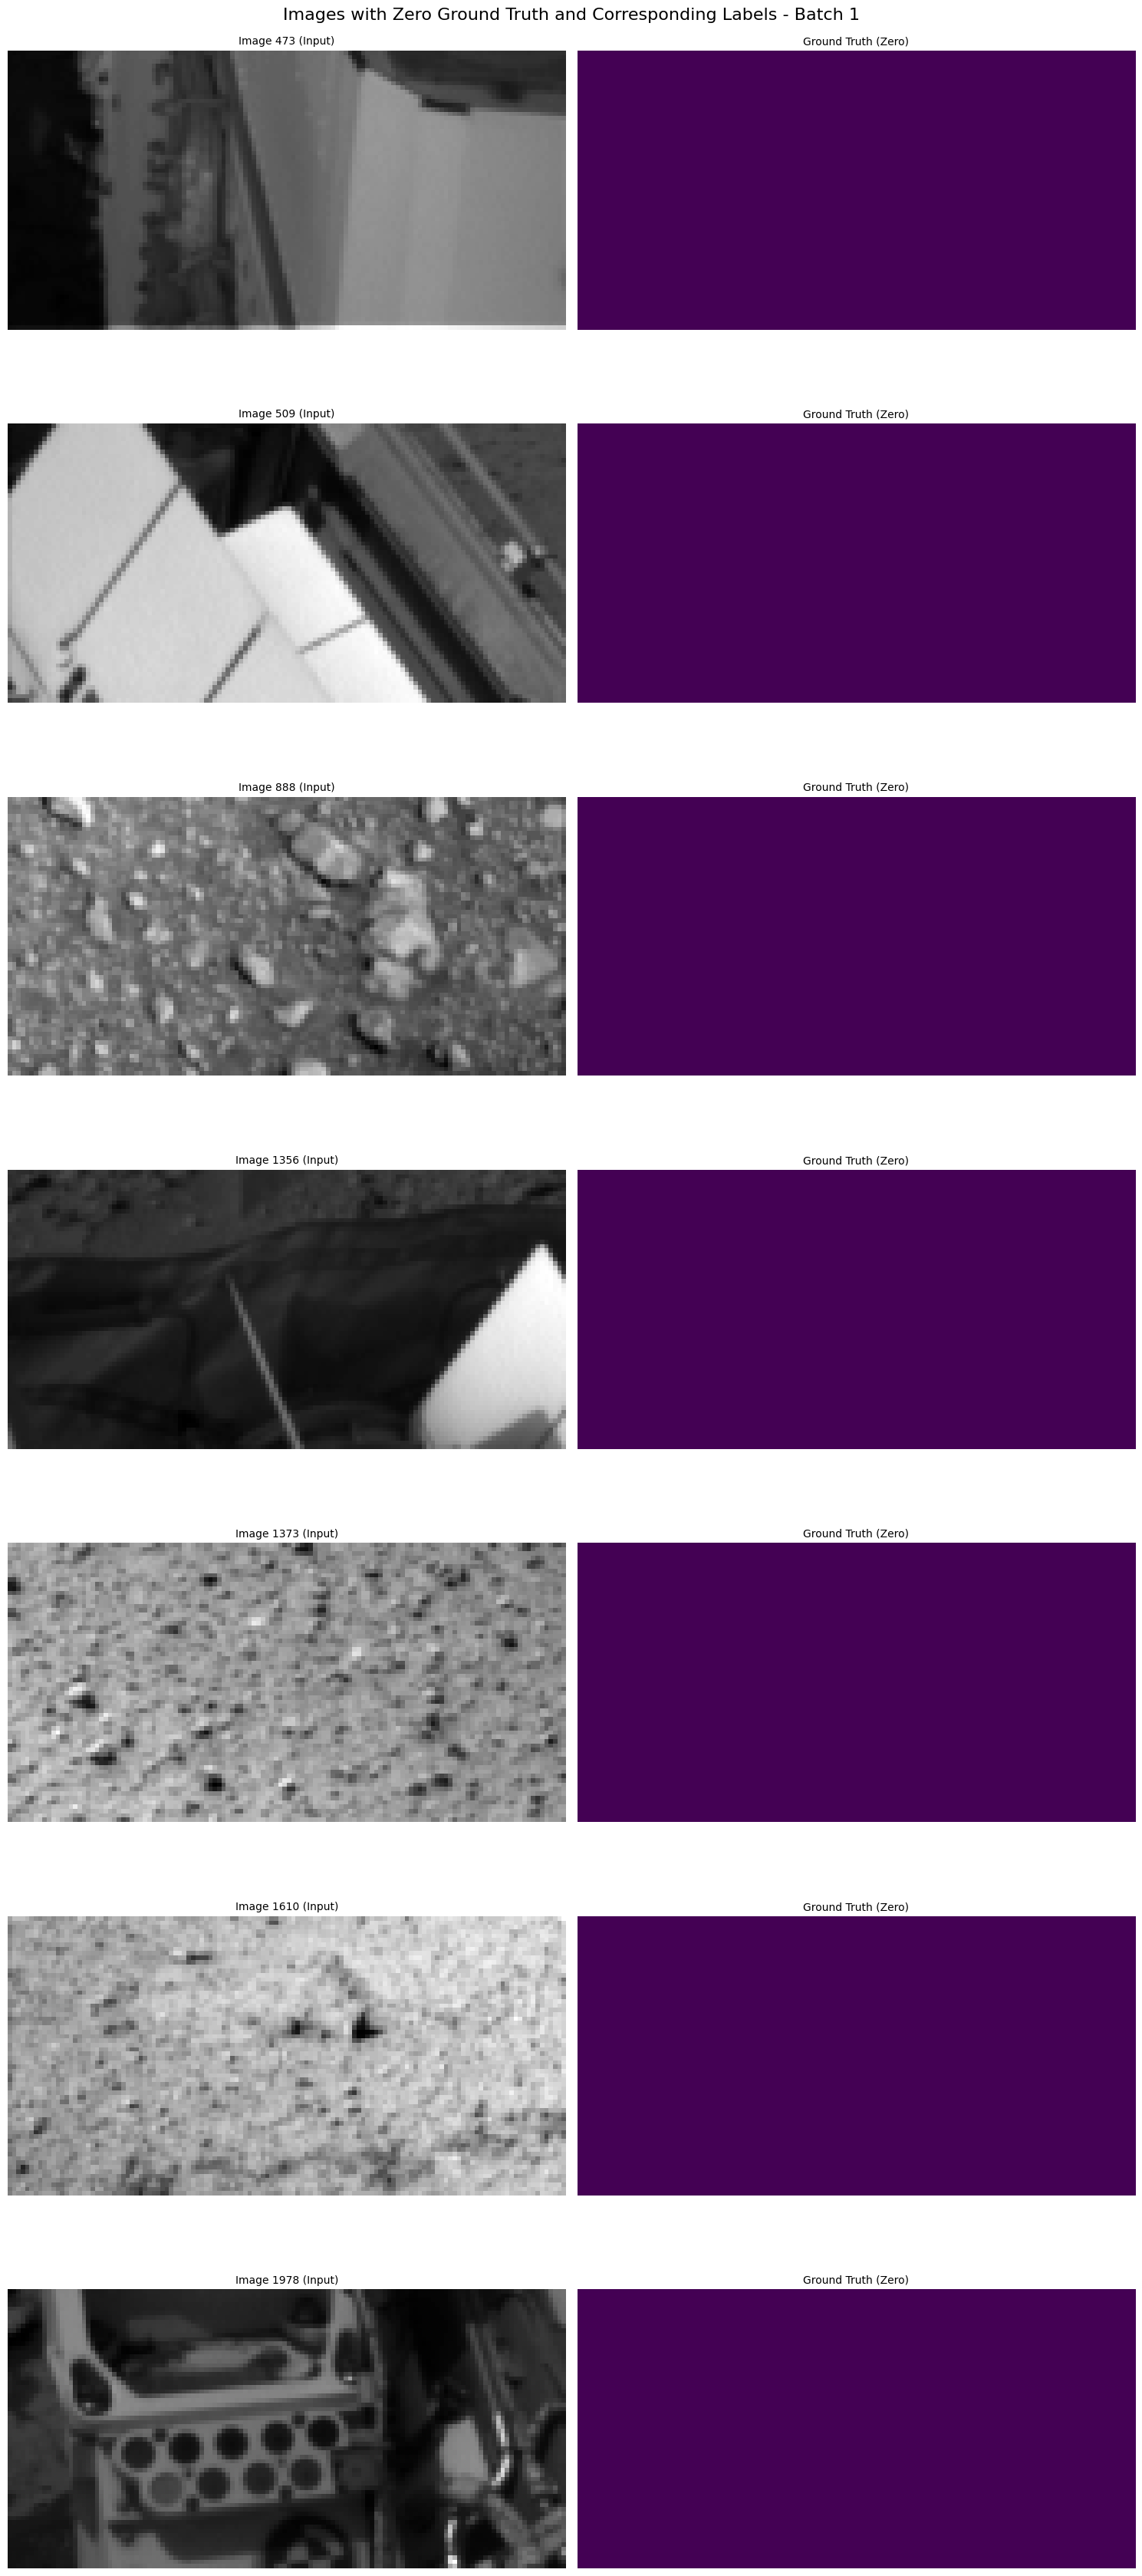

In [35]:
def plot_images_with_zero_ground_truth(images, labels, batch_size=10, title="Images with Zero Ground Truth"):
    # Find indices where the ground truth is a matrix of all zeros
    zero_indices = [i for i, label in enumerate(labels) if np.all(label == 0)]

    if len(zero_indices) == 0:
        print("No images found with ground truth of all zeros.")
        return

    print(f"Found {len(zero_indices)} images with zero ground truth.")

    # Plot all images in batches
    for batch_start in range(0, len(zero_indices), batch_size):
        batch_indices = zero_indices[batch_start:batch_start + batch_size]
        plt.figure(figsize=(15, len(batch_indices) * 5))  # Adjust figure size per batch
        for i, idx in enumerate(batch_indices):
            # Plot Input Image
            plt.subplot(len(batch_indices), 2, i * 2 + 1)
            plt.imshow(images[idx], cmap="gray")
            plt.title(f"Image {idx + 1} (Input)", fontsize=10)
            plt.axis("off")

            # Plot Ground Truth
            plt.subplot(len(batch_indices), 2, i * 2 + 2)
            plt.imshow(labels[idx], cmap="viridis")  # Use a colormap for ground truth
            plt.title(f"Ground Truth (Zero)", fontsize=10)
            plt.axis("off")

        plt.suptitle(f"{title} - Batch {batch_start // batch_size + 1}", fontsize=16)
        plt.tight_layout()
        plt.show()

# Display images with zero ground truth and their corresponding ground truth
plot_images_with_zero_ground_truth(X_train_filtered, y_train_filtered, title="Images with Zero Ground Truth and Corresponding Labels")


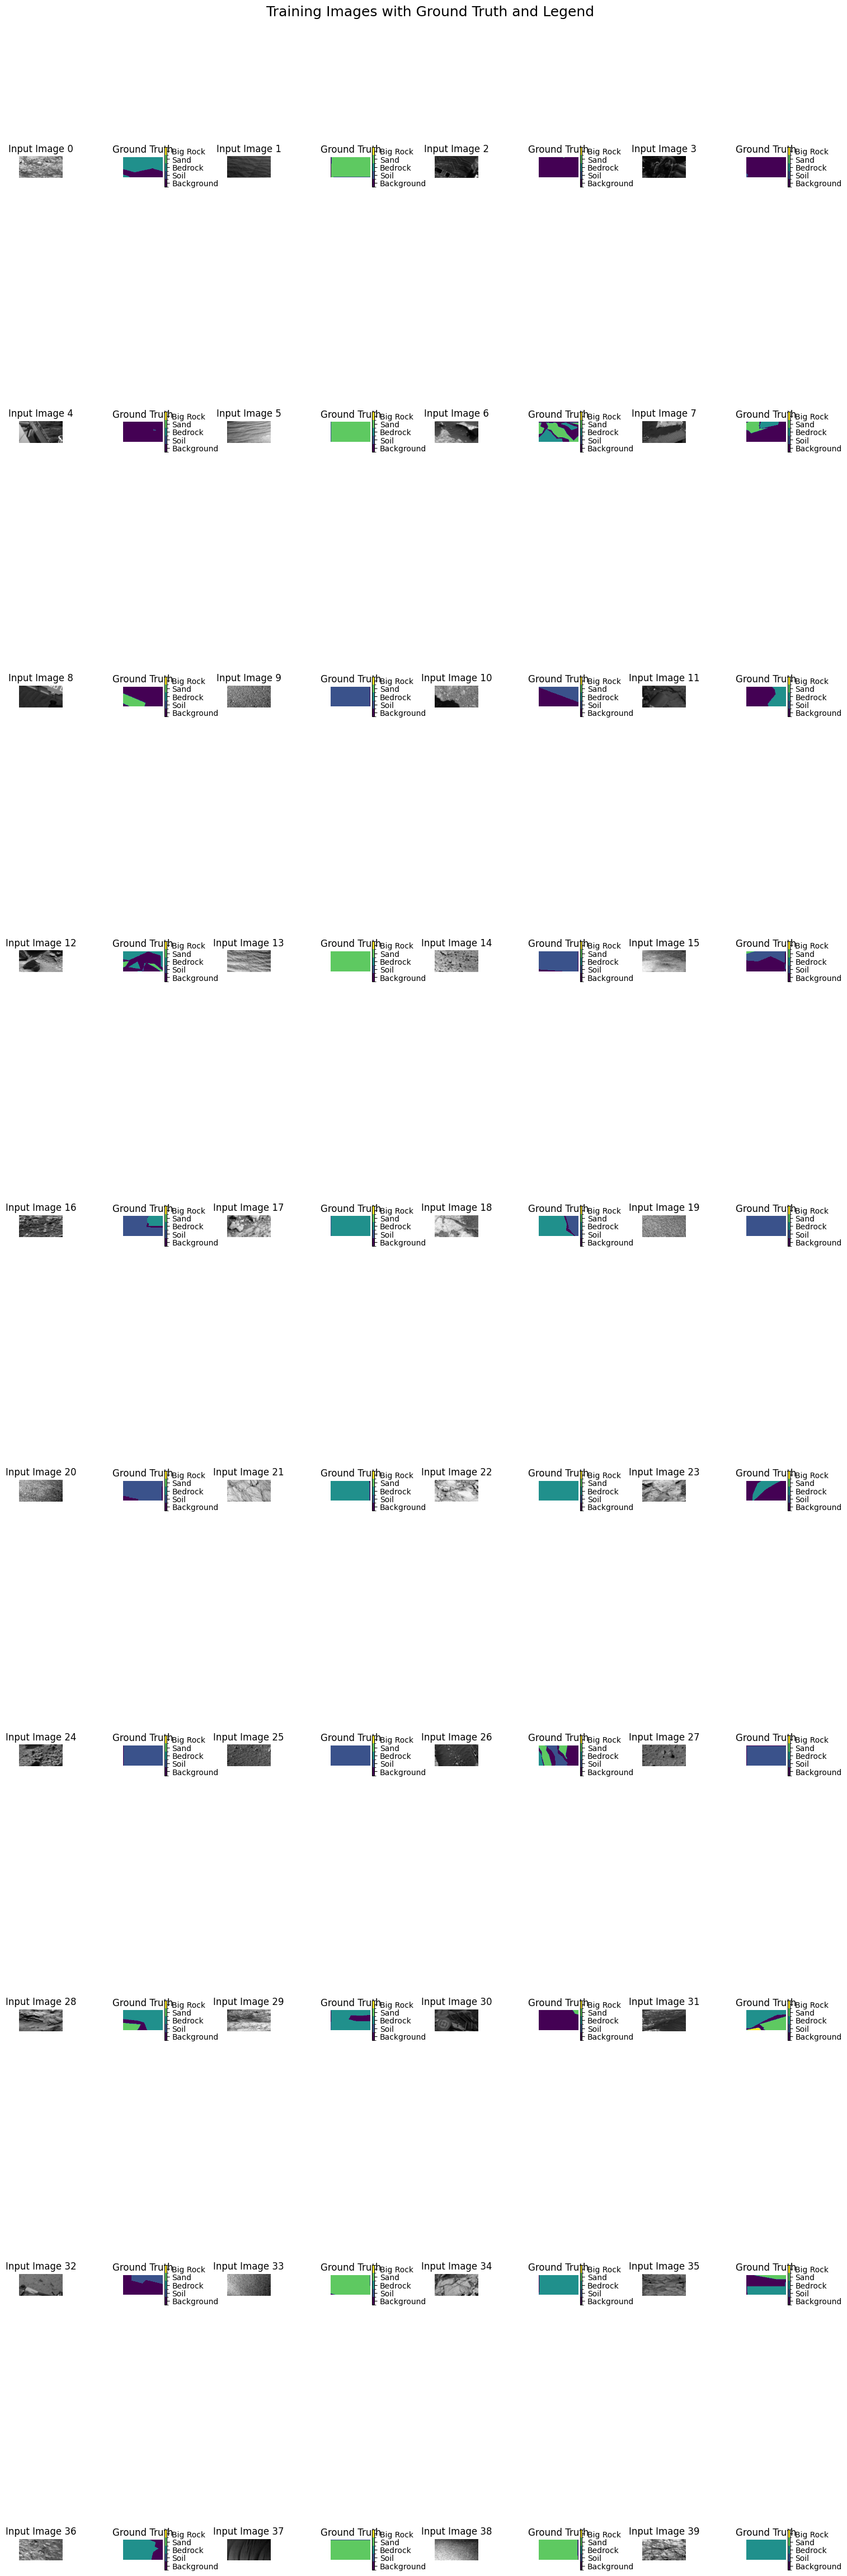

In [36]:
# Check if there are any additional outliers
plot_images_with_ground_truth_and_legend(X_train_filtered, y_train_filtered, rows=10, cols=4, title="Training Images with Ground Truth and Legend")


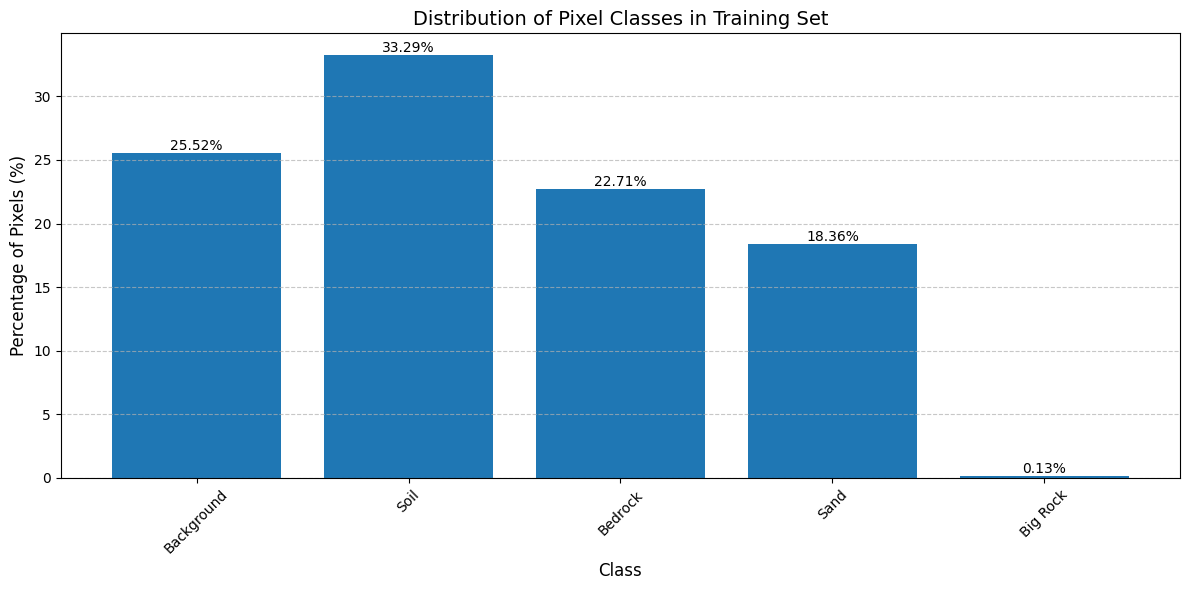

Background: 25.52%
Soil: 33.29%
Bedrock: 22.71%
Sand: 18.36%
Big Rock: 0.13%


In [39]:
# Convert float labels to integers and count pixels per class
y_train_int = y_train.astype(int)  # Convert to integers
pixel_counts = np.bincount(y_train_int.flatten())
pixel_percentages = (pixel_counts / len(y_train_int.flatten())) * 100

# Create histogram
plt.figure(figsize=(12, 6))
bars = plt.bar(range(num_classes), pixel_percentages)

# Customize the plot
plt.title('Distribution of Pixel Classes in Training Set', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Percentage of Pixels (%)', fontsize=12)
plt.xticks(range(num_classes), class_labels, rotation=45)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom')

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

# Print exact values
for label, percentage in zip(class_labels, pixel_percentages):
    print(f"{label}: {percentage:.2f}%")

## def save_filtered_dataset(X_train_filtered, y_train_filtered, X_test, output_path="filtered_dataset.npz"):
    """
    Save the filtered dataset in the same structure as the original dataset.

    Parameters:
        X_train_filtered (array): Filtered training images.
        y_train_filtered (array): Filtered training labels.
        X_test (array): Test images.
        output_path (str): Path to save the filtered dataset.
    """
    # Combine the training data into the same format as the original
    training_set_filtered = np.stack([X_train_filtered, y_train_filtered], axis=1)
    
    # Save the filtered dataset
    np.savez(output_path, training_set=training_set_filtered, test_set=X_test)
    print(f"Filtered dataset saved to {output_path}")

# Example usage:
save_filtered_dataset(X_train_filtered, y_train_filtered, X_test, output_path="no_aliens.npz")
